In [1]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2025-07-02 10:11:28--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.110.153, 185.199.109.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-07-02 10:11:28 (45.3 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1df5

In [2]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

from firedrake.petsc import PETSc

/tmp/ipython-input-4-445986809.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


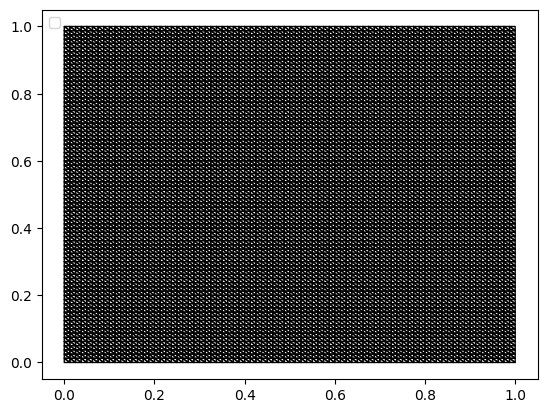

In [4]:
mesh = PeriodicUnitSquareMesh(80 , 80)
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend(loc='upper left')

In [5]:
param = ( {'snes_type':'newtonls', # nonlinear solver types: https://petsc.org/release/manual/snes/#the-nonlinear-solvers
       'snes_monitor':'',        # activate logging options
       'snes_monitoring_lg_residualnorm':'', # print ||G|| at each iteration
       'snes_rtol':1e-4, 'snes_atol':1e-10, 'snes_stol':1e-14, 'snes_maxit':1000
       })

In [6]:
#from dolfin import *
import numpy as np
from numpy.random import random



#Parameters
dt = 2.0e-02

Al=Constant(1.0)
b=Constant(-1.0)
c=Constant(2)
d=Constant(-1.5)
mu=Constant(0.0001)
nu=Constant(0.0006)


G = Constant(0.9)
A = Constant(6.0)
B = Constant(4.0)
D = Constant(20.0)



P1 = FiniteElement("P", triangle, 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element)



# Define functions
(v_1, v_2) = TestFunctions(V)

u_=Function(V) #new solution, time: n
u_1_,u_2_=split(u_)
u_n =Function(V) #old solution, time: n-1
u_n1, u_n2 =split(u_n)

#IC (random initializzation)
#component 1
n0 = u_n.subfunctions[0].dat.data.shape[0]
u_n.subfunctions[0].dat.data[:] = 0.1*np.random.rand(n0) - 0.1*np.random.rand(n0)
# Component 2
n1 = u_n.subfunctions[1].dat.data.shape[0]
u_n.subfunctions[1].dat.data[:] = 0.1*np.random.rand(n1) - 0.1*np.random.rand(n1)


def non_linear_formulation(u_1,u_2,u_n1,u_n2,v_1,v_2):
  F  = 1/dt*inner((u_1-u_n1),v_1)*dx \
     +mu*inner(grad(u_1),grad(v_1))*dx\
     -(Al*u_1+b*u_2)*v_1*dx\
     +1/dt*(u_2-u_n2)*v_2*dx\
     +nu*inner(grad(u_2),grad(v_2))*dx\
     -(c*u_1+d*u_2)*v_2*dx\
     -(u_1 - A*u_2 + G*u_1*u_2 -pow(u_1,3))*v_1*dx\
     -(u_1 - B*u_2)*v_2*dx #forcing term 2
  return F

dwh=TrialFunction(V)
F=non_linear_formulation(u_1_,u_2_,u_n1,u_n2,v_1,v_2)
J=derivative(F,u_,dwh)
Form =NonlinearVariationalProblem(F,u_,J=J)
solver=NonlinearVariationalSolver(Form)

t = 0.0
T=300*dt



#for omogeneus problem
vtkfile_u_1 = File("/content/drive/MyDrive/4Test/pop1.pvd","compressed")
vtkfile_u_2 = File("/content/drive/MyDrive/4Test/pop2.pvd","compressed")



time_vec = np.arange(0, T, dt)  # endtime+0.1*dt to include also endtime: range/arange exclude the upper bound of the range


for ii in range(1, len(time_vec)):     # start from 1 to skip time=0
    t = time_vec[ii]
    print('Time = ', t)
    u_1_,u_2_=split(u_)
    u_n1, u_n2 =split(u_n)
    dwh=TrialFunction(V)
    F=non_linear_formulation(u_1_,u_2_,u_n1,u_n2,v_1,v_2)
    J=derivative(F,u_,dwh)
    Form =NonlinearVariationalProblem(F,u_,J=J)
    solver=NonlinearVariationalSolver(Form,solver_parameters=param)
    solver.solve()


    u_1_,u_2_=u_.subfunctions
    u_n1, u_n2 =u_n.subfunctions

    u_1_.rename("pop_1")   # this name will be used in Paraview
    u_2_.rename("pop_2")
    vtkfile_u_1.write(u_1_, time=t)
    vtkfile_u_2.write(u_2_, time=t)


    u_n1.assign(u_1_)
    u_n2.assign(u_2_)

/usr/local/lib/python3.11/dist-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


Time =  0.02
  0 SNES Function norm 1.944697449469e-02
  1 SNES Function norm 4.091916134726e-06
  2 SNES Function norm 2.528735511974e-13
Time =  0.04
  0 SNES Function norm 5.111264497354e-03
  1 SNES Function norm 1.658154230034e-07
Time =  0.06
  0 SNES Function norm 3.091038500776e-03
  1 SNES Function norm 8.719792726858e-08
Time =  0.08
  0 SNES Function norm 2.158124029367e-03
  1 SNES Function norm 5.298456130036e-08
Time =  0.1
  0 SNES Function norm 1.653539829991e-03
  1 SNES Function norm 3.514883609765e-08
Time =  0.12
  0 SNES Function norm 1.337720036358e-03
  1 SNES Function norm 2.461001780726e-08
Time =  0.14
  0 SNES Function norm 1.117843060903e-03
  1 SNES Function norm 1.782690832307e-08
Time =  0.16
  0 SNES Function norm 9.535846300456e-04
  1 SNES Function norm 1.320244353242e-08
Time =  0.18
  0 SNES Function norm 8.251036095180e-04
  1 SNES Function norm 9.927401753681e-09
Time =  0.2
  0 SNES Function norm 7.215235425159e-04
  1 SNES Function norm 7.5508645

Text(0.5, 1.0, 'population')

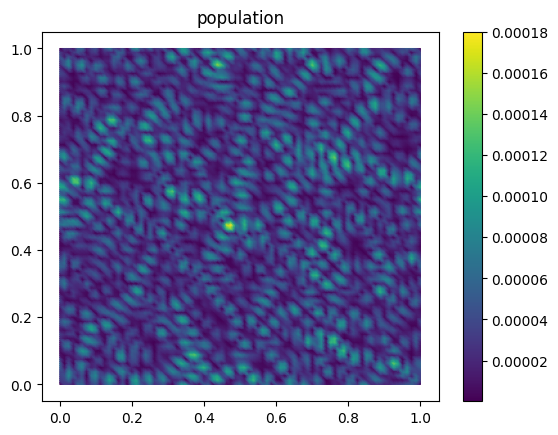

In [7]:
fig, ax = plt.subplots()
col = tripcolor(u_, axes=ax)
plt.colorbar(col)
plt.title('population')